In [1]:
import numpy as np
import pandas as pd
import matplotlib
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from abc import ABCMeta, abstractmethod
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Boosting

In [2]:
def read_data(path):
    data = pd.read_csv(path)
    return data

In [3]:
path = os.path.realpath(os.path.join(os.getcwd() , '..', 'data_for_training', 'BEV_data_w_hpi.csv'))

In [4]:
data = read_data(path)
if "Unnamed: 0.1" in data.columns:
    data = data.drop(["Unnamed: 0.1"], axis = 1)

In [5]:
y = data["number_registration"]
X = data.drop(['number_registration',"zip code" ], axis =1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=88)

In [6]:
def OSR2(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    return (1- SSE/SST)

In [7]:
boosting = GradientBoostingRegressor(random_state=88)
boosting.fit(X_train, y_train)
print("OSR2: ",OSR2(boosting, X_test, y_test, y_train))

OSR2:  0.9129423703112861


### Classification Tree 

In [8]:
bev_data = data.copy(deep=True)

In [9]:
bev_data['class'] = np.zeros(len(bev_data))
for i in range(len(bev_data)):
    if bev_data['number_registration'][i] < 50:
        bev_data['class'][i] = 'A'
    
    elif bev_data['number_registration'][i] < 200:
        bev_data['class'][i] = 'B'
    elif bev_data['number_registration'][i] < 400:
        bev_data['class'][i] = 'C'
    else:
        bev_data['class'][i] = 'D'

/var/folders/hd/7mhwbm312jd2fp_tb35yjgvc0000gn/T/ipykernel_19828/3867495291.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bev_data['class'][i] = 'A'


In [10]:
y = bev_data['class']
X = bev_data.drop(['class', 'zip code', 'number_registration'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 88)

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

dtc = DecisionTreeClassifier(class_weight = 'balanced',
                             min_samples_leaf= 3,
                             min_samples_split= 2,
                              random_state = 88)
cv = KFold(n_splits= 10, random_state= 88, shuffle = True)
grid_values = {'ccp_alpha': np.linspace(0,1,2001)}

dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=cv, verbose=0)


dtc_cv_acc = dtc_cv_acc.fit(X_train, y_train)

y_pred = dtc_cv_acc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
print('Precision:',precision_score(y_test, y_pred, average = 'weighted'))
print('Recall:',recall_score(y_test, y_pred, average = 'weighted'))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])

Confusion Matrix : 
 [[42  4  0  0]
 [10 22  7  1]
 [ 0  4 10  3]
 [ 0  0  2 16]]
Precision: 0.7424342802333234
Recall: 0.743801652892562


/var/folders/hd/7mhwbm312jd2fp_tb35yjgvc0000gn/T/ipykernel_19828/2264077292.py:26: RuntimeWarning: invalid value encountered in long_scalars
  TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])


In [12]:
model_acc = dtc_cv_acc.best_score_ # TODO: calculate CV CART accuracy
print(f'CART Best Accuracy: {model_acc:.4f}')

CART Best Accuracy: 0.7187


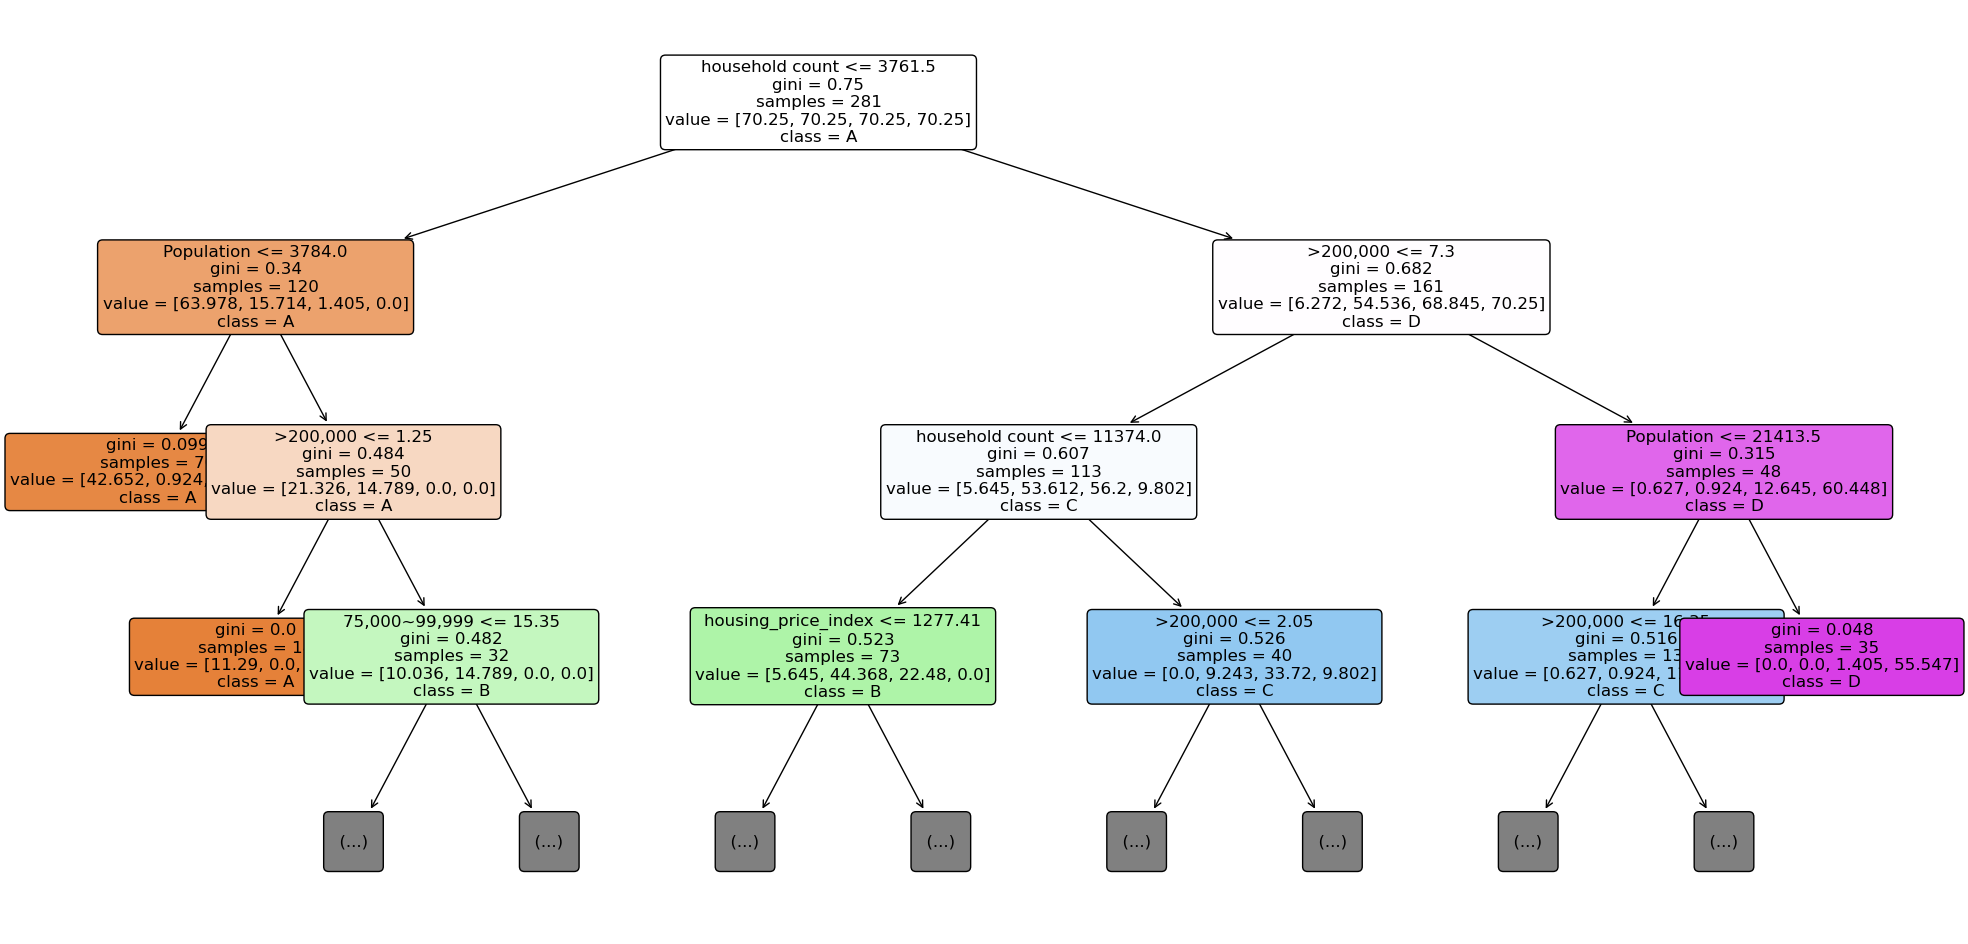

In [13]:
from sklearn.tree import plot_tree
plt.figure(figsize=(24,12))
plot_tree(dtc_cv_acc.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['A','B','C','D'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()

## Regression Tree

In [14]:
y = data["number_registration"]
X = data.drop(['number_registration',"zip code" ], axis =1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=88)

In [15]:
grid_values = {'ccp_alpha': np.linspace(0, 1, 2001),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

            
dtr = DecisionTreeRegressor()
dtr_cv_acc = GridSearchCV(dtr, param_grid = grid_values, cv=10, verbose=0, scoring = 'r2')
dtr = dtr_cv_acc.fit(X_train, y_train)

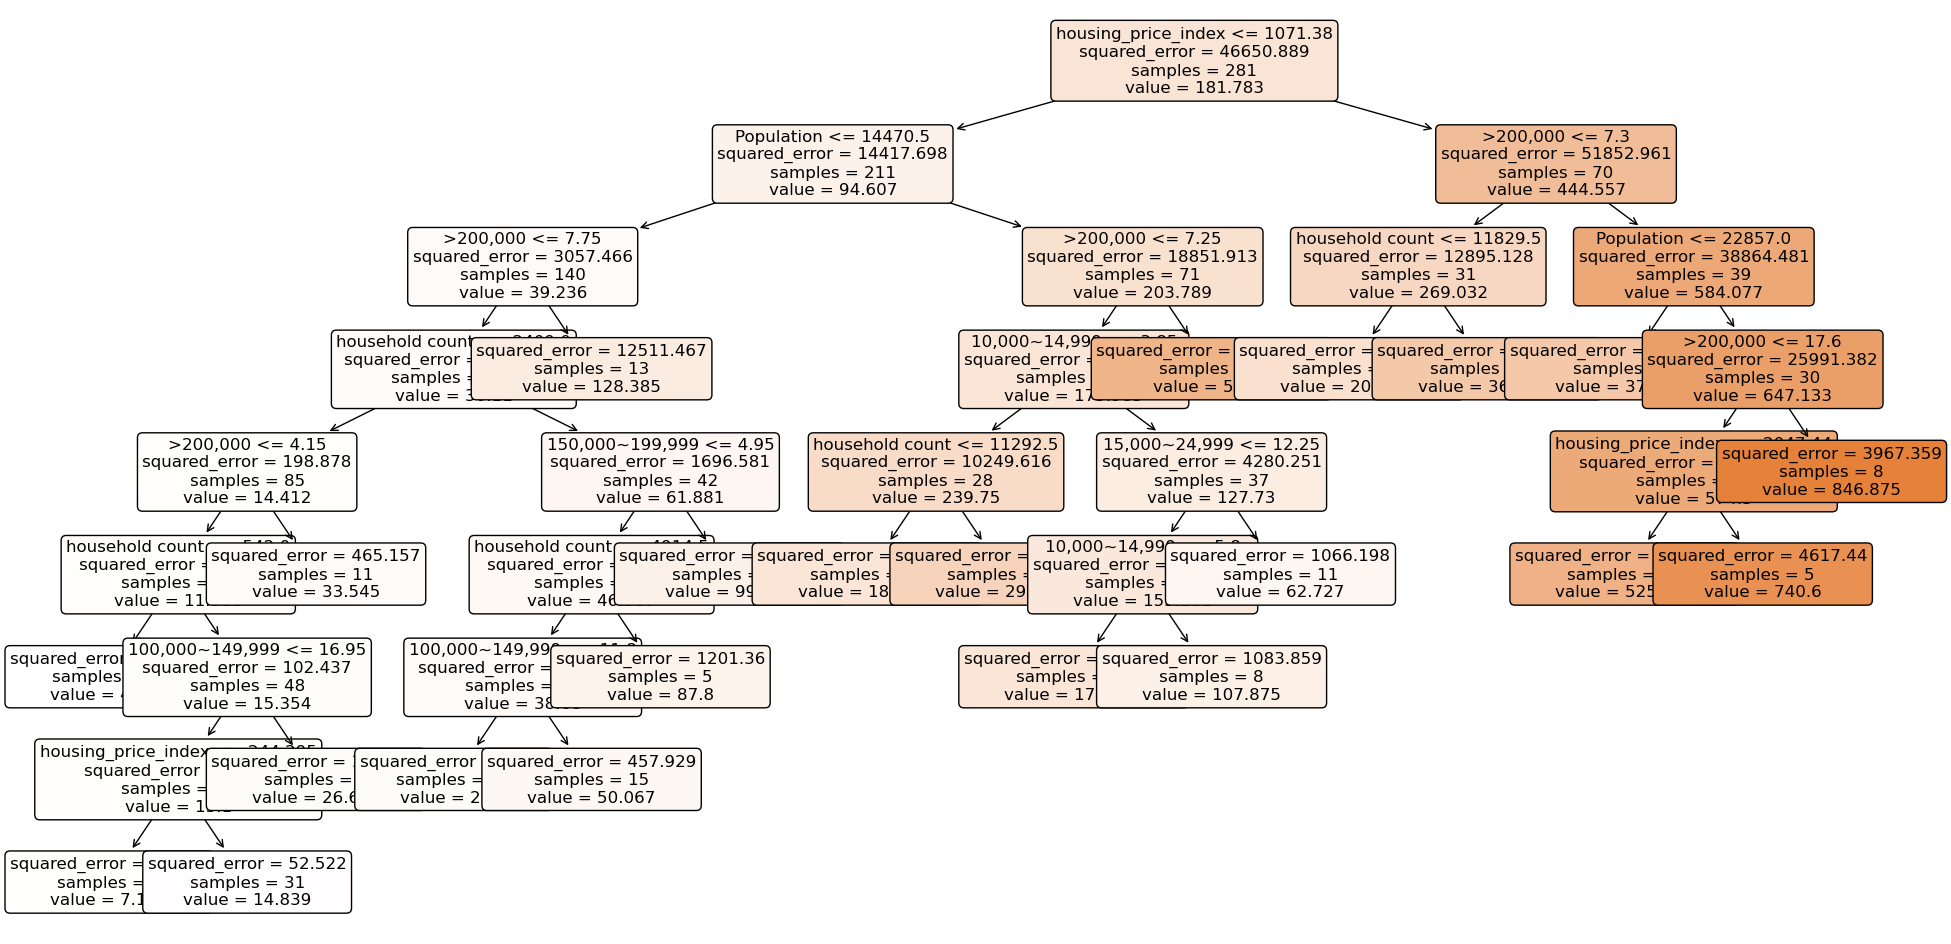

In [16]:
plt.figure(figsize=(24,12))
plot_tree(dtr_cv_acc.best_estimator_, 
          feature_names=X_train.columns,
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) #,max_depth=3)   # how deep to show
plt.show()

In [17]:
print("Regression Tree OSR2: ",OSR2(dtr, X_test, y_test, y_train))

Regression Tree OSR2:  0.8090644387025876


### Linear Regression

#### Detailed process of how the features are selected, please look at the notebook(model_LR), following is the best model

In [18]:
path = os.path.realpath(os.path.join(os.getcwd() , '..', 'data_for_training', 'BEV_data_w_hpi.csv'))

In [19]:
data = read_data(path)
if "Unnamed: 0.1" in data.columns:
    data = data.drop(["Unnamed: 0.1"], axis = 1)

In [20]:
#  Description of the dataset
Description_data = {'Variable': ['zip code',
                                 'number_registration',
                                 'Population',
                                 'household count',
                                 '<10,000',
                                 '10,000~14,999',
                                 '15,000~24,999',
                                 '25,000~34,999',
                                 '35,000~49,999',
                                 '50,000~74,999',
                                 '75,000~99,999',
                                 '100,000~149,999',
                                 '150,000~199,999',
                                 '>200,000',
                                 'EV charging station number',
                                 'housing_price_index'],
                    
                    'Description': ['United States Zip Codes',
                                    'The number of electric vehicle registrations',
                                    'The number of Population',
                                    'The number of household',
                                    'The income less than \$10,000',
                                    'The income from \$10,000 to \$14,999',
                                    'The income from \$15,000 to \$24,999',
                                    'The income from \$25,000 to \$34,999',
                                    'The income from \$35,000 to \$49,999',
                                    'The income from \$50,000 to \$74,999',
                                    'The income from \$75,000 to \$99,999',
                                    'The income from \$100,000 to \$149,999',
                                    'The income from \$150,000 to \$199,999',
                                    'The income more than \$200,000',
                                    'EV charging station number',
                                    'housing price index'
                                   ]}

Description_table = pd.DataFrame(data=Description_data, index=['zip code',
                                                               'number_registration',
                                                               'Population',
                                                               'household count',
                                                               '<10,000',
                                                               '10,000~14,999',
                                                               '15,000~24,999',
                                                               '25,000~34,999',
                                                               '35,000~49,999',
                                                               '50,000~74,999',
                                                               '75,000~99,999',
                                                               '100,000~149,999',
                                                               '150,000~199,999',
                                                               '>200,000',
                                                               'EV charging station number',
                                                               'housing_price_index'])
Description_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,Variable,Description
zip code,zip code,United States Zip Codes
number_registration,number_registration,The number of electric vehicle registrations
Population,Population,The number of Population
household count,household count,The number of household
"<10,000","<10,000","The income less than \$10,000"
"10,000~14,999","10,000~14,999","The income from \$10,000 to \$14,999"
"15,000~24,999","15,000~24,999","The income from \$15,000 to \$24,999"
"25,000~34,999","25,000~34,999","The income from \$25,000 to \$34,999"
"35,000~49,999","35,000~49,999","The income from \$35,000 to \$49,999"
"50,000~74,999","50,000~74,999","The income from \$50,000 to \$74,999"


In [21]:
data.columns = [
'Zip_code',
'Number_registration',
'Population',
'Household_count',
'Less_than_10000',
'10000to14999',
'15000to24999',
'25000to34999',
'35000to49999',
'50000to74999',
'75000to99999',
'100000to149999',
'150000to199999',
'More_than_200000',
'EV_charging_station_number',
'Housing_price_index']

In [22]:
data.corr()

,Zip_code,Number_registration,Population,Household_count,Less_than_10000,10000to14999,15000to24999,25000to34999,35000to49999,50000to74999,75000to99999,100000to149999,150000to199999,More_than_200000,EV_charging_station_number,Housing_price_index
Zip_code,1.000000,-0.560675,-0.274067,-0.307336,0.172310,0.207461,0.374355,0.351308,0.319722,0.216820,-0.079457,-0.340045,-0.438706,-0.443717,-0.248258,-0.556051
Number_registration,-0.560675,1.000000,0.667800,0.710470,-0.190113,-0.330070,-0.427181,-0.432270,-0.443963,-0.404947,0.052155,0.396289,0.628389,0.704902,0.417548,0.816300
Population,-0.274067,0.667800,1.000000,0.982454,-0.023831,-0.204565,-0.159393,-0.167895,-0.211256,-0.174889,0.133700,0.166918,0.266496,0.224121,0.258704,0.668722
Household_count,-0.307336,0.710470,0.982454,1.000000,-0.001950,-0.193053,-0.156807,-0.176619,-0.228123,-0.206830,0.112308,0.166539,0.280854,0.254496,0.334510,0.719770
Less_than_10000,0.172310,-0.190113,-0.023831,-0.001950,1.000000,0.301747,0.437142,0.246241,0.003324,-0.218999,-0.211997,-0.359535,-0.370015,-0.276957,0.121224,-0.058866
10000to14999,0.207461,-0.330070,-0.204565,-0.193053,0.301747,1.000000,0.463554,0.272347,0.133087,-0.080471,-0.182824,-0.483755,-0.401137,-0.365410,-0.039394,-0.243117
15000to24999,0.374355,-0.427181,-0.159393,-0.156807,0.437142,0.463554,1.000000,0.401396,0.326289,0.028941,-0.298700,-0.633605,-0.577593,-0.509545,-0.103129,-0.313299
25000to34999,0.351308,-0.432270,-0.167895,-0.176619,0.246241,0.272347,0.401396,1.000000,0.333483,0.176920,-0.299535,-0.569441,-0.505113,-0.513768,-0.150369,-0.337624
35000to49999,0.319722,-0.443963,-0.211256,-0.228123,0.003324,0.133087,0.326289,0.333483,1.000000,0.202819,-0.313543,-0.493065,-0.478091,-0.445591,-0.193813,-0.336723
50000to74999,0.216820,-0.404947,-0.174889,-0.206830,-0.218999,-0.080471,0.028941,0.176920,0.202819,1.000000,-0.089364,-0.166056,-0.443383,-0.459670,-0.210714,-0.308421


In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# The dataframe passed to VIF must include the intercept term. We add it the same way we did before.
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

In [24]:
y = data["Number_registration"]
X = data.drop(['Number_registration'], axis =1).fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

In [25]:
print(len(X_test))

121


In [26]:
# Import the library that contains all the functions/modules related to the regression model
import statsmodels.api as sm
# Choose the features to be used
subcols_More_than_200000_Household_count_150000to199999= [
# 'Zip_code',
'Population',
#'Household_count',
'Less_than_10000',
'10000to14999',
'15000to24999',
'25000to34999',
'35000to49999',
'50000to74999',
'75000to99999',
'100000to149999',
#'150000to199999',
#'More_than_200000',
'EV_charging_station_number',
'Housing_price_index']

# y = data["Number_registration"]
# X = data.drop(['Number_registration',"Zip_code" ], axis =1).fillna(0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

X_train= X_train[subcols_More_than_200000_Household_count_150000to199999]
X_test = X_test[subcols_More_than_200000_Household_count_150000to199999]
# We must add an intercept as the standard model doesn't automatically fit one
X_train = sm.add_constant(X_train)

# Fit the data to the model
model_More_than_200000_Household_count_150000to199999= sm.OLS(y_train, X_train).fit() #ordinary least square
print(model_More_than_200000_Household_count_150000to199999.summary())
print('After remove More_than_200000,we get VIFs:')
print(VIF(data,subcols_More_than_200000_Household_count_150000to199999))

                             OLS Regression Results                            
Dep. Variable:     Number_registration   R-squared:                       0.841
Model:                             OLS   Adj. R-squared:                  0.835
Method:                  Least Squares   F-statistic:                     129.5
Date:                 Tue, 29 Nov 2022   Prob (F-statistic):          1.29e-100
Time:                         23:45:13   Log-Likelihood:                -1650.7
No. Observations:                  281   AIC:                             3325.
Df Residuals:                      269   BIC:                             3369.
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const     

# CART BASELINE

In [27]:
ev_sales = pd.read_csv("../data_for_training/BEV_data.csv")

In [28]:
def OSR2(model, x_test, y_test, y_train): 
    y_pred = model.predict(x_test) 
    SSE = np.sum((y_test - y_pred)**2) 
    SST = np.sum((y_test - np.mean(y_train))**2) 

    return (1 - SSE/SST)

In [29]:
from sklearn.model_selection import train_test_split

y = ev_sales["number_registration"]
X = pd.get_dummies(ev_sales.drop(["number_registration"],axis=1)) 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88) 
x_train.shape, x_test.shape

((281, 14), (121, 14))

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold 

grid_values = {"ccp_alpha": np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)

cv = KFold(n_splits=5, random_state=1, shuffle=True) 

dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0) 
dtr_cv.fit(x_train, y_train)
print(dtr_cv)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                             min_samples_split=20,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.0e+00, 2.0e-05, 4.0e-05, 6.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
       1.4e-04, 1.6e-04, 1.8e-04, 2.0e-04, 2.2e-04, 2.4e-04, 2.6e-04,
       2.8e-04, 3.0e-04, 3.2e-04, 3.4e-04, 3.6e-04, 3.8e-04, 4.0e-04,
       4.2e-04, 4.4e-04, 4.6e-04, 4.8e-04, 5.0e-04, 5.2e-04, 5.4e-04,
       5.6e-04, 5.8e-04, 6.0e-04, 6.2e-04, 6.4e-04, 6.6e-04, 6.8e-04,
       7.0e-04, 7.2e-04, 7.4e-04, 7.6e-04, 7.8e-04, 8.0e-04, 8.2e-04,
       8.4e-04, 8.6e-04, 8.8e-04, 9.0e-04, 9.2e-04, 9.4e-04, 9.6e-04,
       9.8e-04, 1.0e-03])},
             scoring='r2')


[0.0 2e-05 4e-05 6.000000000000001e-05 8e-05 0.0001 0.00012000000000000002
 0.00014000000000000001 0.00016 0.00018 0.0002 0.00022
 0.00024000000000000003 0.00026000000000000003 0.00028000000000000003
 0.00030000000000000003 0.00032 0.00034 0.00036 0.00038 0.0004 0.00042
 0.00044 0.00046 0.00048000000000000007 0.0005 0.0005200000000000001
 0.00054 0.0005600000000000001 0.00058 0.0006000000000000001 0.00062
 0.00064 0.0006600000000000001 0.00068 0.0007000000000000001 0.00072
 0.0007400000000000001 0.00076 0.0007800000000000001 0.0008
 0.0008200000000000001 0.00084 0.0008600000000000001 0.00088
 0.0009000000000000001 0.00092 0.0009400000000000001 0.0009600000000000001
 0.0009800000000000002 0.001]
[0.76869905 0.76869905 0.76869905 0.76869905 0.76869905 0.76869905
 0.76869905 0.76869905 0.76869905 0.76869905 0.76869905 0.76869905
 0.76869905 0.76869905 0.76869905 0.76869905 0.76869905 0.76869905
 0.76869905 0.76869905 0.76869905 0.76869905 0.76869905 0.76869905
 0.76869905 0.76869905 0.768

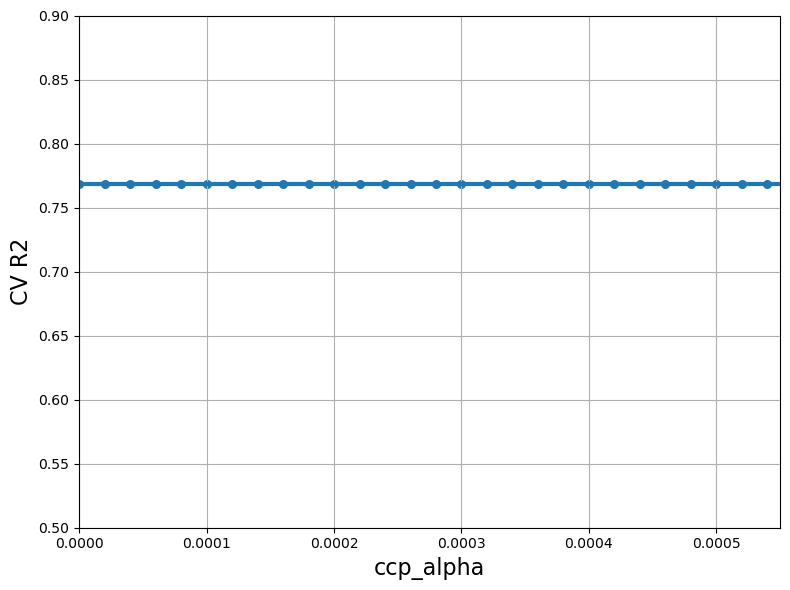

In [31]:
ccp_alpha = dtr_cv.cv_results_['param_ccp_alpha'].data 
print(ccp_alpha)
R2_scores = dtr_cv.cv_results_['mean_test_score'] 
print(R2_scores)

plt.figure(figsize=(8,6)) 
plt.xlabel('ccp_alpha', fontsize=16) 
plt.ylabel('CV R2', fontsize=16) 
plt.scatter(ccp_alpha, R2_scores, s=30)
plt.plot(ccp_alpha, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([0, 0.00055])
plt.ylim([0.5, 0.9])

plt.tight_layout()
plt.show()

In [32]:
print('Best ccp_alpha', dtr_cv.best_params_)

Best ccp_alpha {'ccp_alpha': 0.0}


In [33]:
#Model Evaluation 

print('Cross-validated R2:', round(dtr_cv.best_score_,5))
print('OSR2:', round(OSR2(dtr_cv, x_test, y_test, y_train), 5))

Cross-validated R2: 0.7687
OSR2: 0.81047


##  Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor 

rf = RandomForestRegressor(max_features=5, min_samples_leaf=5, 
                            n_estimators = 500, random_state=88, verbose=2)

rf.fit(x_train, y_train)

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished


RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=500,
                      random_state=88, verbose=2)

In [35]:
rf.verbose = False

print('OSR2:', round(OSR2(rf, x_test, y_test, y_train), 5))

OSR2: 0.908


In [36]:
pd.DataFrame({'Feature': x_train.columns, 
                'Importance score': 100*rf.feature_importances_}).round(1)

,Feature,Importance score
0,zip code,18.8
1,Population,16.2
2,household count,19.1
3,"<10,000",0.3
4,"10,000~14,999",0.6
5,"15,000~24,999",1.3
6,"25,000~34,999",2.5
7,"35,000~49,999",3.7
8,"50,000~74,999",2.2
9,"75,000~99,999",1.4


In [37]:
## Using GridSearchCV to find best max_features 

import time 

grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'), 
                'min_samples_leaf': [5],
                'n_estimators': [500], 
                'random_state': [88]} 

time0 = time.time()

rf2 = RandomForestRegressor()

cv = KFold(n_splits=5, random_state=333, shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv, verbose=2) 
rf_cv.fit(x_train, y_train) 

time1 = time.time()

print('time:', round(time1-time0, 2), 's')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_e

[CV] END max_features=17, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.1s
[CV] END max_features=17, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.1s
[CV] END max_features=18, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.1s
[CV] END max_features=18, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.1s
[CV] END max_features=18, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.1s
[CV] END max_features=18, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.1s
[CV] END max_features=18, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.1s


/Users/rich1999/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rich1999/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rich1999/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/rich1999/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iter

time: 37.53 s


[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18]
[0.76980641 0.83979806 0.86120098 0.86516843 0.86803275 0.86780657
 0.86927051 0.866763   0.8680828  0.86410749 0.86182796 0.85851971
 0.85446475 0.85176454        nan        nan        nan        nan]


(0.7, 0.9)

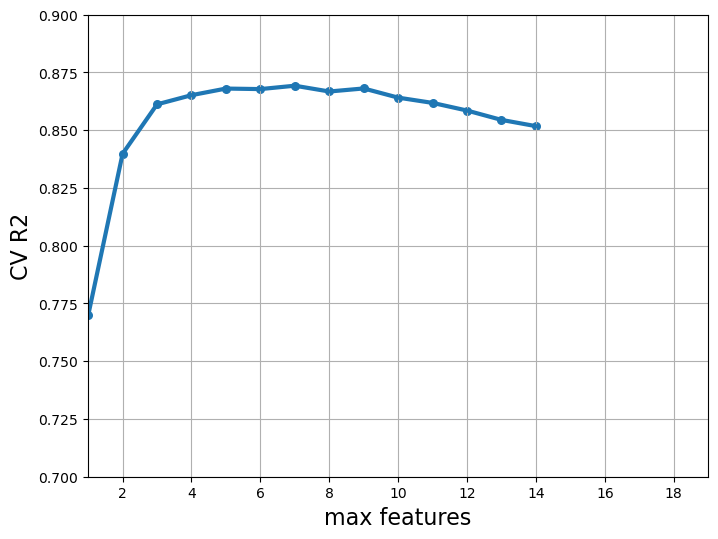

In [38]:
max_features = rf_cv.cv_results_['param_max_features'].data 
print(max_features)
R2_scores = rf_cv.cv_results_['mean_test_score']
print(R2_scores)

plt.figure(figsize=(8,6)) 
plt.xlabel('max features', fontsize=16) 
plt.ylabel('CV R2', fontsize=16) 
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 19])
plt.ylim([0.7, 0.9])

In [39]:
print(rf_cv.best_params_)

{'max_features': 7, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


In [40]:
# Evaluate model performance 
print('Cross-validated R2:', round(rf_cv.best_score_, 5)) 
print('OSR2:', round(OSR2(rf_cv, x_test,y_test,y_train), 5))

Cross-validated R2: 0.86927
OSR2: 0.91086


In [41]:
pd.DataFrame({'Feature': x_train.columns, 
                'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)

,Feature,Importance score
0,zip code,22.2
1,Population,16.0
2,household count,19.9
3,"<10,000",0.4
4,"10,000~14,999",0.5
5,"15,000~24,999",0.7
6,"25,000~34,999",1.4
7,"35,000~49,999",3.0
8,"50,000~74,999",2.7
9,"75,000~99,999",1.4


<BarContainer object of 14 artists>

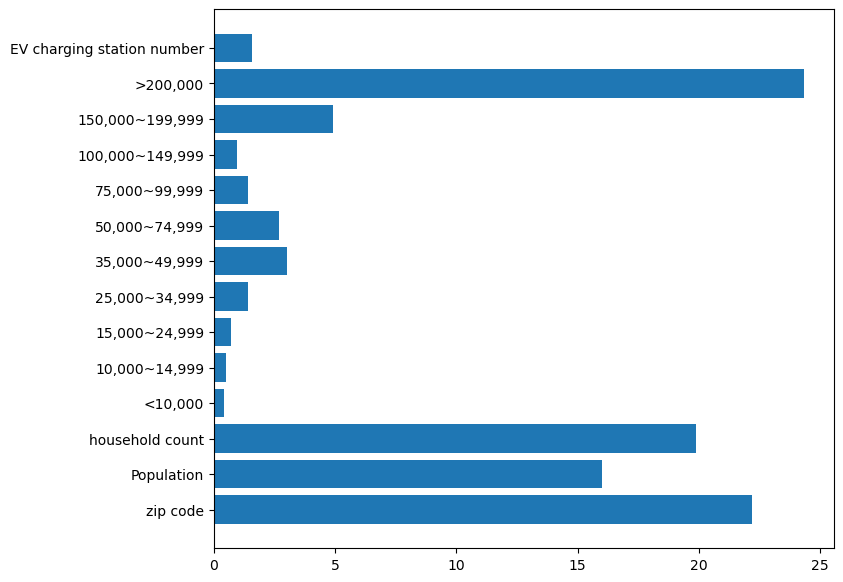

In [42]:
#visualize feature importances 

plt.figure(figsize=(8,7))
plt.barh(x_train.columns, 100*rf_cv.best_estimator_.feature_importances_)

# Boostrap Testing

In [43]:
ev_sales = pd.read_csv("../data_for_training/BEV_data.csv")
from sklearn.model_selection import train_test_split

y = ev_sales["number_registration"]
X = pd.get_dummies(ev_sales.drop(["number_registration"],axis=1)) 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88) 

In [44]:
def read_data(path):
    data = pd.read_csv(path)
    return data
path = os.path.realpath(os.path.join(os.getcwd() , '..', 'data_for_training', 'BEV_data_w_hpi.csv'))
data = read_data(path)
if "Unnamed: 0.1" in data.columns:
    data = data.drop(["Unnamed: 0.1"], axis = 1)
y = data["number_registration"]
X = data.drop(['number_registration',"zip code" ], axis =1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=88)

In [45]:
def OSR2(model, x_test, y_test, y_train): 
    y_pred = model.predict(x_test) 
    SSE = np.sum((y_test - y_pred)**2) 
    SST = np.sum((y_test - np.mean(y_train))**2) 

    return (1 - SSE/SST)

In [46]:
from sklearn.metrics import accuracy_score
def perform_bootstrap(test_data, test_label, model,y_train, sample=500, random_state=88):# FILL IN ARGUMENTS) -> dict: 
    n_sample = sample
#     accuracy_array=np.zeros(n_sample)
#     accuracy_array[:]=np.nan
#     TPR_array = np.zeros(n_sample)
#     TPR_array[:] = np.nan
#     FPR_array = np.zeros(n_sample)
#     FPR_array[:]=np.nan
    boosting_array = np.zeros(n_sample)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True) 
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
#         bs_predicted = model.predict(bs_data)
        temp_OSR2 = OSR2(model, bs_data,bs_label,y_train)
#         temp_OSR2 = OSR2(model, x_test,y_test,y_train)
        boosting_array[bs_iter] = temp_OSR2
#         accuracy_array[bs_iter]=accuracy_score(bs_label, bs_predicted)
#         cm = confusion_matrix(bs_label, bs_predicted)
#         tn, fp, fn, tp = cm.ravel()
#         TPR_array[bs_iter]= (tp)/(tp+fn)
#         FPR_array[bs_iter] = (fp)/(tn+fp)
    boosting_df = pd.DataFrame(boosting_array)
    return boosting_df

In [47]:
boosting_OSR2_df =perform_bootstrap(X_test, y_test, boosting, y_train,
                          sample = 500)

In [48]:
def draw_performance_histogram(data, name):
    plt.figure()
    plt.hist(data, label=name)
    plt.legend()
    plt.show() 

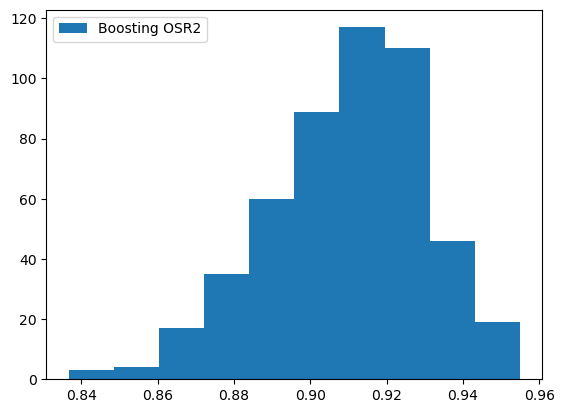

In [49]:
draw_performance_histogram(boosting_OSR2_df, "Boosting OSR2")

In [50]:
decision_tree_regressor_OSR2_df =perform_bootstrap(X_test, y_test, boosting, y_train,
                          sample = 500)

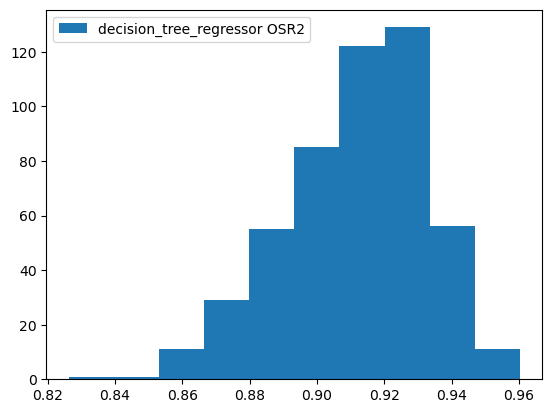

In [51]:
draw_performance_histogram(decision_tree_regressor_OSR2_df, "decision_tree_regressor OSR2")

In [52]:
data = read_data(path)
if "Unnamed: 0.1" in data.columns:
    data = data.drop(["Unnamed: 0.1"], axis = 1)
    

In [53]:
data.columns = [
'Zip_code',
'Number_registration',
'Population',
'Household_count',
'Less_than_10000',
'10000to14999',
'15000to24999',
'25000to34999',
'35000to49999',
'50000to74999',
'75000to99999',
'100000to149999',
'150000to199999',
'More_than_200000',
'EV_charging_station_number',
'Housing_price_index']

In [54]:
y = data["Number_registration"]
X = data.drop(['Number_registration'], axis =1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

In [55]:
# Import the library that contains all the functions/modules related to the regression model
import statsmodels.api as sm
# Choose the features to be used
subcols_More_than_200000_Household_count_150000to199999= [
# 'Zip_code',
'Population',
#'Household_count',
'Less_than_10000',
'10000to14999',
'15000to24999',
'25000to34999',
'35000to49999',
'50000to74999',
'75000to99999',
'100000to149999',
#'150000to199999',
#'More_than_200000',
'EV_charging_station_number',
'Housing_price_index']

# y = data["Number_registration"]
# X = data.drop(['Number_registration',"Zip_code" ], axis =1).fillna(0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

X_train= X_train[subcols_More_than_200000_Household_count_150000to199999]
X_test = X_test[subcols_More_than_200000_Household_count_150000to199999]
X_train = sm.add_constant(X_train)

In [56]:
X_test = sm.add_constant(X_test)

In [57]:
linear_regression_OSR2_df = perform_bootstrap(X_test, y_test, model_More_than_200000_Household_count_150000to199999, y_train,
                          sample = 500)

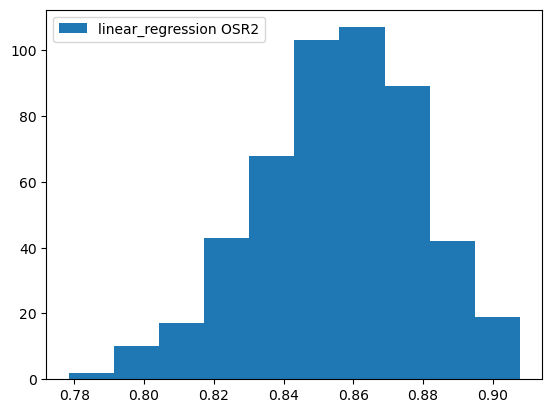

In [58]:
draw_performance_histogram(linear_regression_OSR2_df, "linear_regression OSR2")